# Compare observed monthly sea ice extent with meridional wind, using scatterplots and contour plots

#### filepaths, dates etc

In [1]:
latmin = -65. ; latmax = -55. # latitude range over which to average wind


#sea ice extent
isrc = 'NSIDC'
diri = '/g/data/gv90/wrh581/'+isrc+'/'
iNam = 'SIA'


# merid wind
asrc  = 'era5'
aNam = 'v10'
dira = '/g/data/rt52/'+asrc+'/single-levels/monthly-averaged/10v/'

#output filepath


#### sector definitions

Potential issue below: the Ross Sector spans across longitudes that include both the poleward branch and the equatorward branch in the atmospheric flow around the Amundsen Sea Low. We might want to select longitude ranges that pick regions based on the ZW3 pattern, i.e. regions with poleward flow and regions with equatorward flow. Perhaps this could be done using long-term time averaged wind fields to begin with.

In [2]:
sector = {
        'Ross' : {'minlon' : 175., 'maxlon' : 220.},
        'Amundsen' : {'minlon' : 220., 'maxlon' : 277.},
        'Bellingshausen' : {'minlon' : 277.,  'maxlon' : 295.},
        'Weddell' : {'minlon' : 327., 'maxlon' : 10.},
        'King Haakon' : {'minlon' : 10., 'maxlon' : 70.}
    }

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import glob
import numpy as np
import xarray as xr
import cf_xarray as cf
import calendar
import scipy.stats as stats
import pandas as pd
import datetime
from pathlib import Path

%matplotlib inline

### read SIA

SIA is read in from gv90/wrh581/. The units are $10^6\,$km$^2\,$ per degree longitude.

In [4]:
fili = glob.glob(diri+'NSIDC_SH_icearea_v0?r00_*.nc')


In [5]:

fili = glob.glob(diri+'NSIDC_SH_icearea_v0?r00_*.nc')
SIA = xr.open_mfdataset(fili, parallel = True)

#add datetime array
SIA['time'] = [datetime.datetime.strptime(str(date), "%Y%m") for date in SIA.time.values]
SIA = (SIA['SIA'] * 1.e-6).compute() 



### read wind

The meridional wind is read in from project "rt52" which reproduces ERA5 fields on Gadi. The meridional wind is then spatially averaged between latitudes 65ºS to 55ºS.

In [38]:

#string list of years for same range as sea ice data      
yrst = SIA.time[0].dt.year.values ; yren = SIA.time.max().dt.year.values
yrstring = [str(yr) for yr in  np.arange(yrst,yren+1) ]

cmd = 'ls '+dira+'{'+','.join(yrstring)+'}/*.nc  2>/dev/null'
fila = !$cmd

adata = xr.open_mfdataset(fila, parallel = True)


#get mean
adata = adata.cf.sel(latitude = slice(latmax, latmin))
wgts  = np.cos(np.deg2rad(adata.cf['latitude']))
wind_merid = adata[aNam].weighted(wgts).mean(adata.cf['latitude'].name).compute()

#change lon coord to 0-360 (if necessary)
pivot = wind_merid.cf['longitude'].min().values
if (pivot < 0.):

    xtmp = wind_merid.cf['longitude'].values
    xtmp = np.where(xtmp < 0., xtmp+360., xtmp)
    
wind_merid[wind_merid.cf['longitude'].name] = xtmp


In [39]:
dira_u10 = '/g/data/rt52/era5/single-levels/monthly-averaged/10u/'
#string list of years for same range as sea ice data      
yrst = SIA.time[0].dt.year.values ; yren = SIA.time.max().dt.year.values
yrstring = [str(yr) for yr in  np.arange(yrst,yren+1) ]

cmd = 'ls '+dira_u10+'{'+','.join(yrstring)+'}/*.nc  2>/dev/null'
fila = !$cmd

adata_u = xr.open_mfdataset(fila, parallel = True)


#get mean
adata_u = adata_u.cf.sel(latitude = slice(latmax, latmin))
wgts  = np.cos(np.deg2rad(adata_u.cf['latitude']))
wind_zonal = adata_u["u10"].weighted(wgts).mean(adata_u.cf['latitude'].name).compute()

#change lon coord to 0-360 (if necessary)
pivot = wind_zonal.cf['longitude'].min().values
if (pivot < 0.):

    xtmp = wind_zonal.cf['longitude'].values
    xtmp = np.where(xtmp < 0., xtmp+360., xtmp)
    
wind_zonal[wind_zonal.cf['longitude'].name] = xtmp


### calculate sector anomalies

In [35]:
sector_mean = xr.Dataset(
    data_vars = {'SIA' : (['sector','month','year'], np.full( (len(sector),12,(yren-yrst+1)), np.nan)),
                 'v10' : (['sector','month','year'],np.full( (len(sector),12,(yren-yrst+1)), np.nan)),
                 'u10' : (['sector','month','year'],np.full( (len(sector),12,(yren-yrst+1)), np.nan))},
    coords = {'sector' : list(sector.keys()),
              'month' : np.arange(1,13), 
              'year' : np.arange(yrst, yren+1)}
            )

In [21]:
def lon_selection(var, xmin, xmax):
    if xmin < xmax:
        var_sel = var.where((var.cf['longitude'] <= xmax) & (var.cf['longitude'] > xmin))
    else:
        #this covers case where sector crosses the longitude pivot point
        var_sel = var.where((var.cf['longitude'] <= xmax) | (var.cf['longitude'] > xmin))
    return var_sel

def time_reord(var):
    var_reord = var.assign_coords(year=var['time.year'],month=var['time.month'])
    var_reord = var_reord.groupby(['year', 'month']).mean(dim='time')
    return var_reord    

In [40]:

for sname in sector:
    xmin = sector[sname]['minlon']
    xmax = sector[sname]['maxlon']

    ## Meridional wind
    
    tmp = lon_selection(wind_merid, xmin, xmax)#.sel(time = sector_mean.time)
    tmp = tmp.mean(tmp.cf['longitude'].name)
    sector_mean['v10'].loc[{'sector' : sname}] = time_reord(tmp)

    ## zonal wind
    
    tmp = lon_selection(wind_zonal, xmin, xmax)#.sel(time = sector_mean.time)
    tmp = tmp.mean(tmp.cf['longitude'].name)
    sector_mean['u10'].loc[{'sector' : sname}] = time_reord(tmp)
    
    #SIE
    tmp = lon_selection(SIA, xmin, xmax)
    tmp = tmp.sum(tmp.cf['longitude'].name)
    sector_mean['SIA'].loc[{'sector' : sname}] =  time_reord(tmp)



sector_mean = sector_mean - sector_mean.mean('year').compute()

#mask instrument dropouts from sea ice
sector_mean['SIA'].loc[{'year' :1987, 'month' :12}] = np.nan
sector_mean['SIA'].loc[{'year' :1988, 'month' :1}] = np.nan



### Time plot (by sector) of wind vs sea ice

In [41]:
def wind_ice_tplot(plot_sector, plot_month, ax, wind_field = "v10"):
    selcond = {'sector' : plot_sector, 'month' : plot_month}

    sector_mean['SIA'].sel(**selcond).plot(ax=ax, c='k')
    plt.axhline(0.,c='k')
    plt.ylim([-1.,1.])
    ax.set_ylabel('SIA anom (million km$^2$)', fontsize = 15, color='k')
    plt.title('')

    ax2 = ax.twinx()
    sector_mean[wind_field].sel(**selcond).plot(ax=ax2, c='r')
    plt.ylim([-3.,3.])
    plt.title('')

    if wind_field == "v10":
        ylabel = 'v wind anom (ms$^-1$)'
    elif wind_field == "u10":
        ylabel = 'u wind anom (ms$^-1$)'
    else:
        raise ValueError("wind_field has to have a value of either v10 or u10.")

    ax2.set_ylabel(ylabel, fontsize = 15, color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    ax.set_title(calendar.month_name[plot_month],fontsize = 20, loc = 'left')


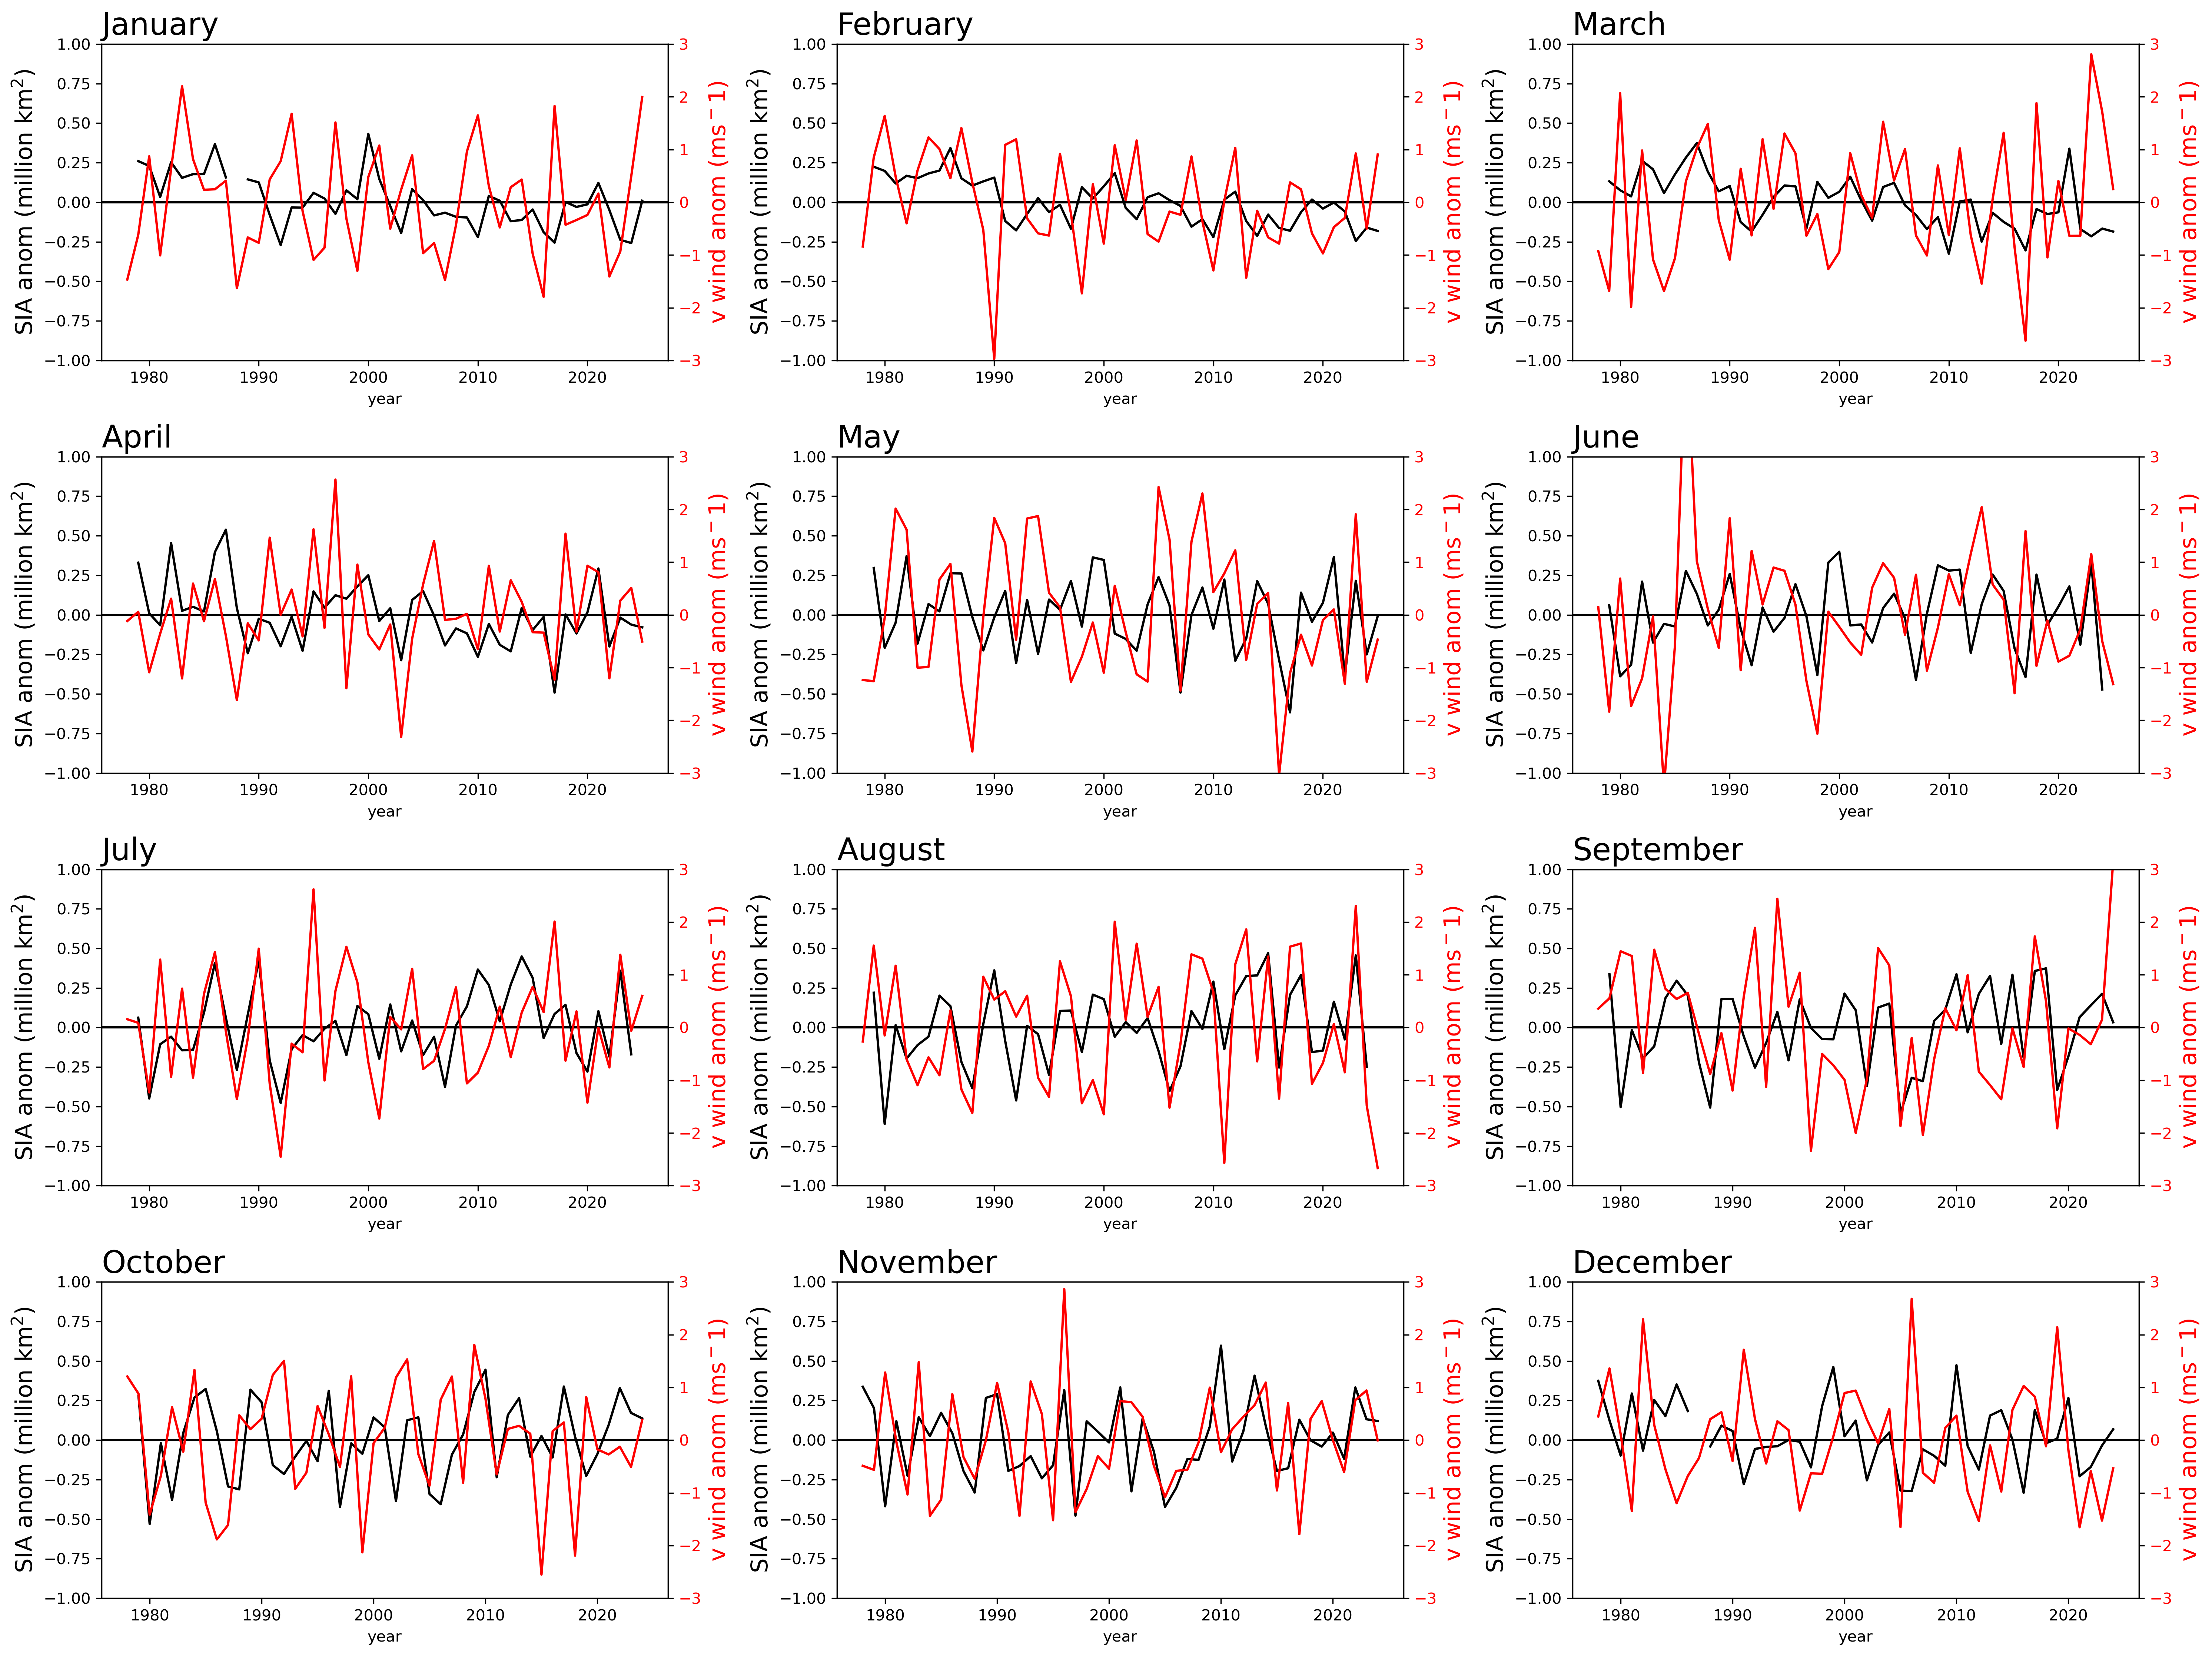

In [69]:
plt.figure(figsize=(20,15), dpi=300)
plsec =   'Amundsen'

for m in range(1,13):
        ax = plt.subplot(4, 3, m)
        wind_ice_tplot(plsec,m, ax, wind_field="v10")

plt.tight_layout()
plt.show()

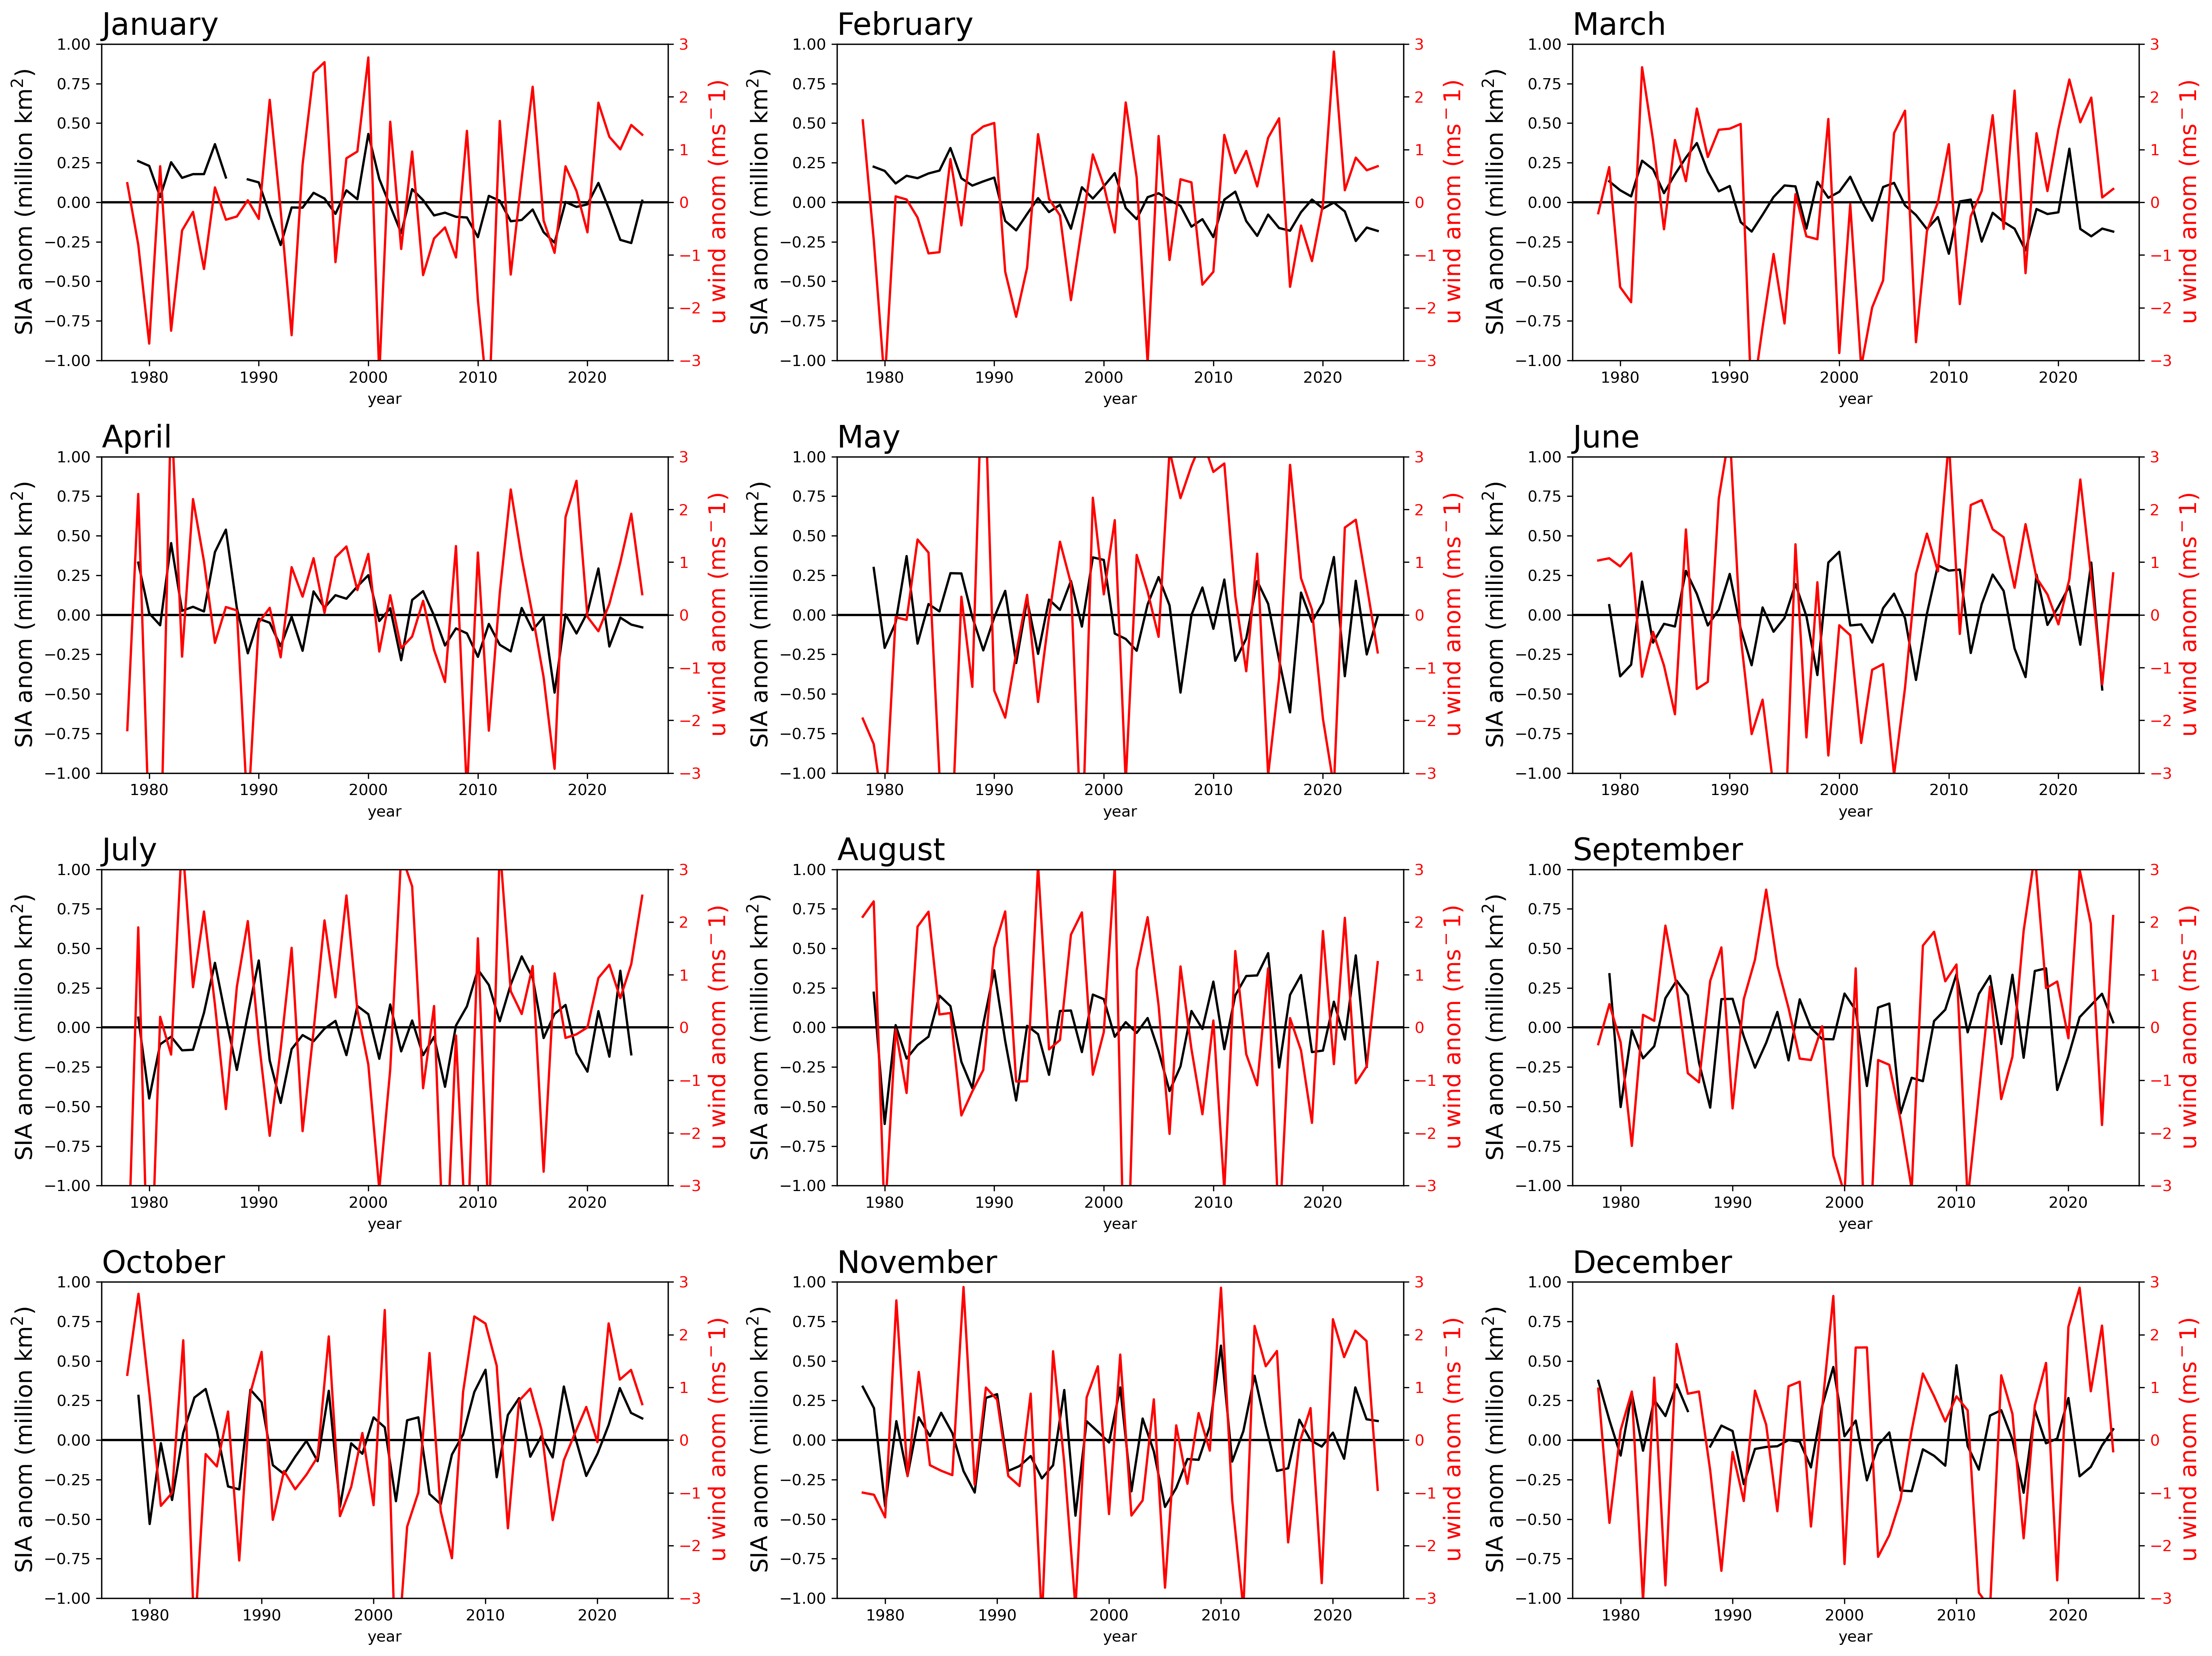

In [68]:
plt.figure(figsize=(20,15), dpi=300)
plsec =   'Amundsen'

for m in range(1,13):
        ax = plt.subplot(4, 3, m)
        wind_ice_tplot(plsec,m, ax, wind_field="u10")

plt.tight_layout()
plt.show()

### Scatter plot for selected month/longitude range

In [65]:
calendar

<module 'calendar' from '/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/calendar.py'>

In [66]:

def wind_ice_scatter(plot_sector, plot_month, refyears, wind_field = "v10", region_name="", include_region_name=False):

    selcond = {'sector' : plot_sector, 'month' : plot_month}

    x    = sector_mean[wind_field].sel(**selcond)
    y    = sector_mean['SIA'].sel(**selcond)
    mask = np.isfinite(x) & np.isfinite(y)
    x    = x[mask] ; y = y[mask]

    plt.scatter(x.values,y.values, s = 15, c='darkgray')

    #plot selected reference years in red
    selcond.update({'year' : refyears})
    plt.scatter(sector_mean[wind_field].sel(**selcond).values,
                      sector_mean['SIA'].sel(**selcond).values,
                s =60, c='red')

    #regression line
    regfit = stats.linregress(x.values, y.values)
    plt.plot(x, x*regfit.slope + regfit.intercept, c = 'k', linewidth = 1.5,)

    
    plt.axhline(0.,c='k', linestyle='--', linewidth=1.)
    plt.axvline(0.,c='k', linestyle='--',linewidth=1.)
    plt.ylabel('SIA (million km$^2$)', fontsize = 15)

    if wind_field == "v10":
        xlabel = 'v wind (ms$^-1$)'
    elif wind_field == "u10":
        xlabel = 'u wind (ms$^-1$)'
    else:
        raise ValueError("wind_field has to have a value of either v10 or u10.")
        
    plt.xlabel(xlabel, fontsize = 15)
    if include_region_name:
        plt.title(calendar.month_abbr[plot_month]+", "+region_name,fontsize = 20, loc = 'left')    
    else:
        plt.title(calendar.month_abbr[plot_month],fontsize = 20, loc = 'left')

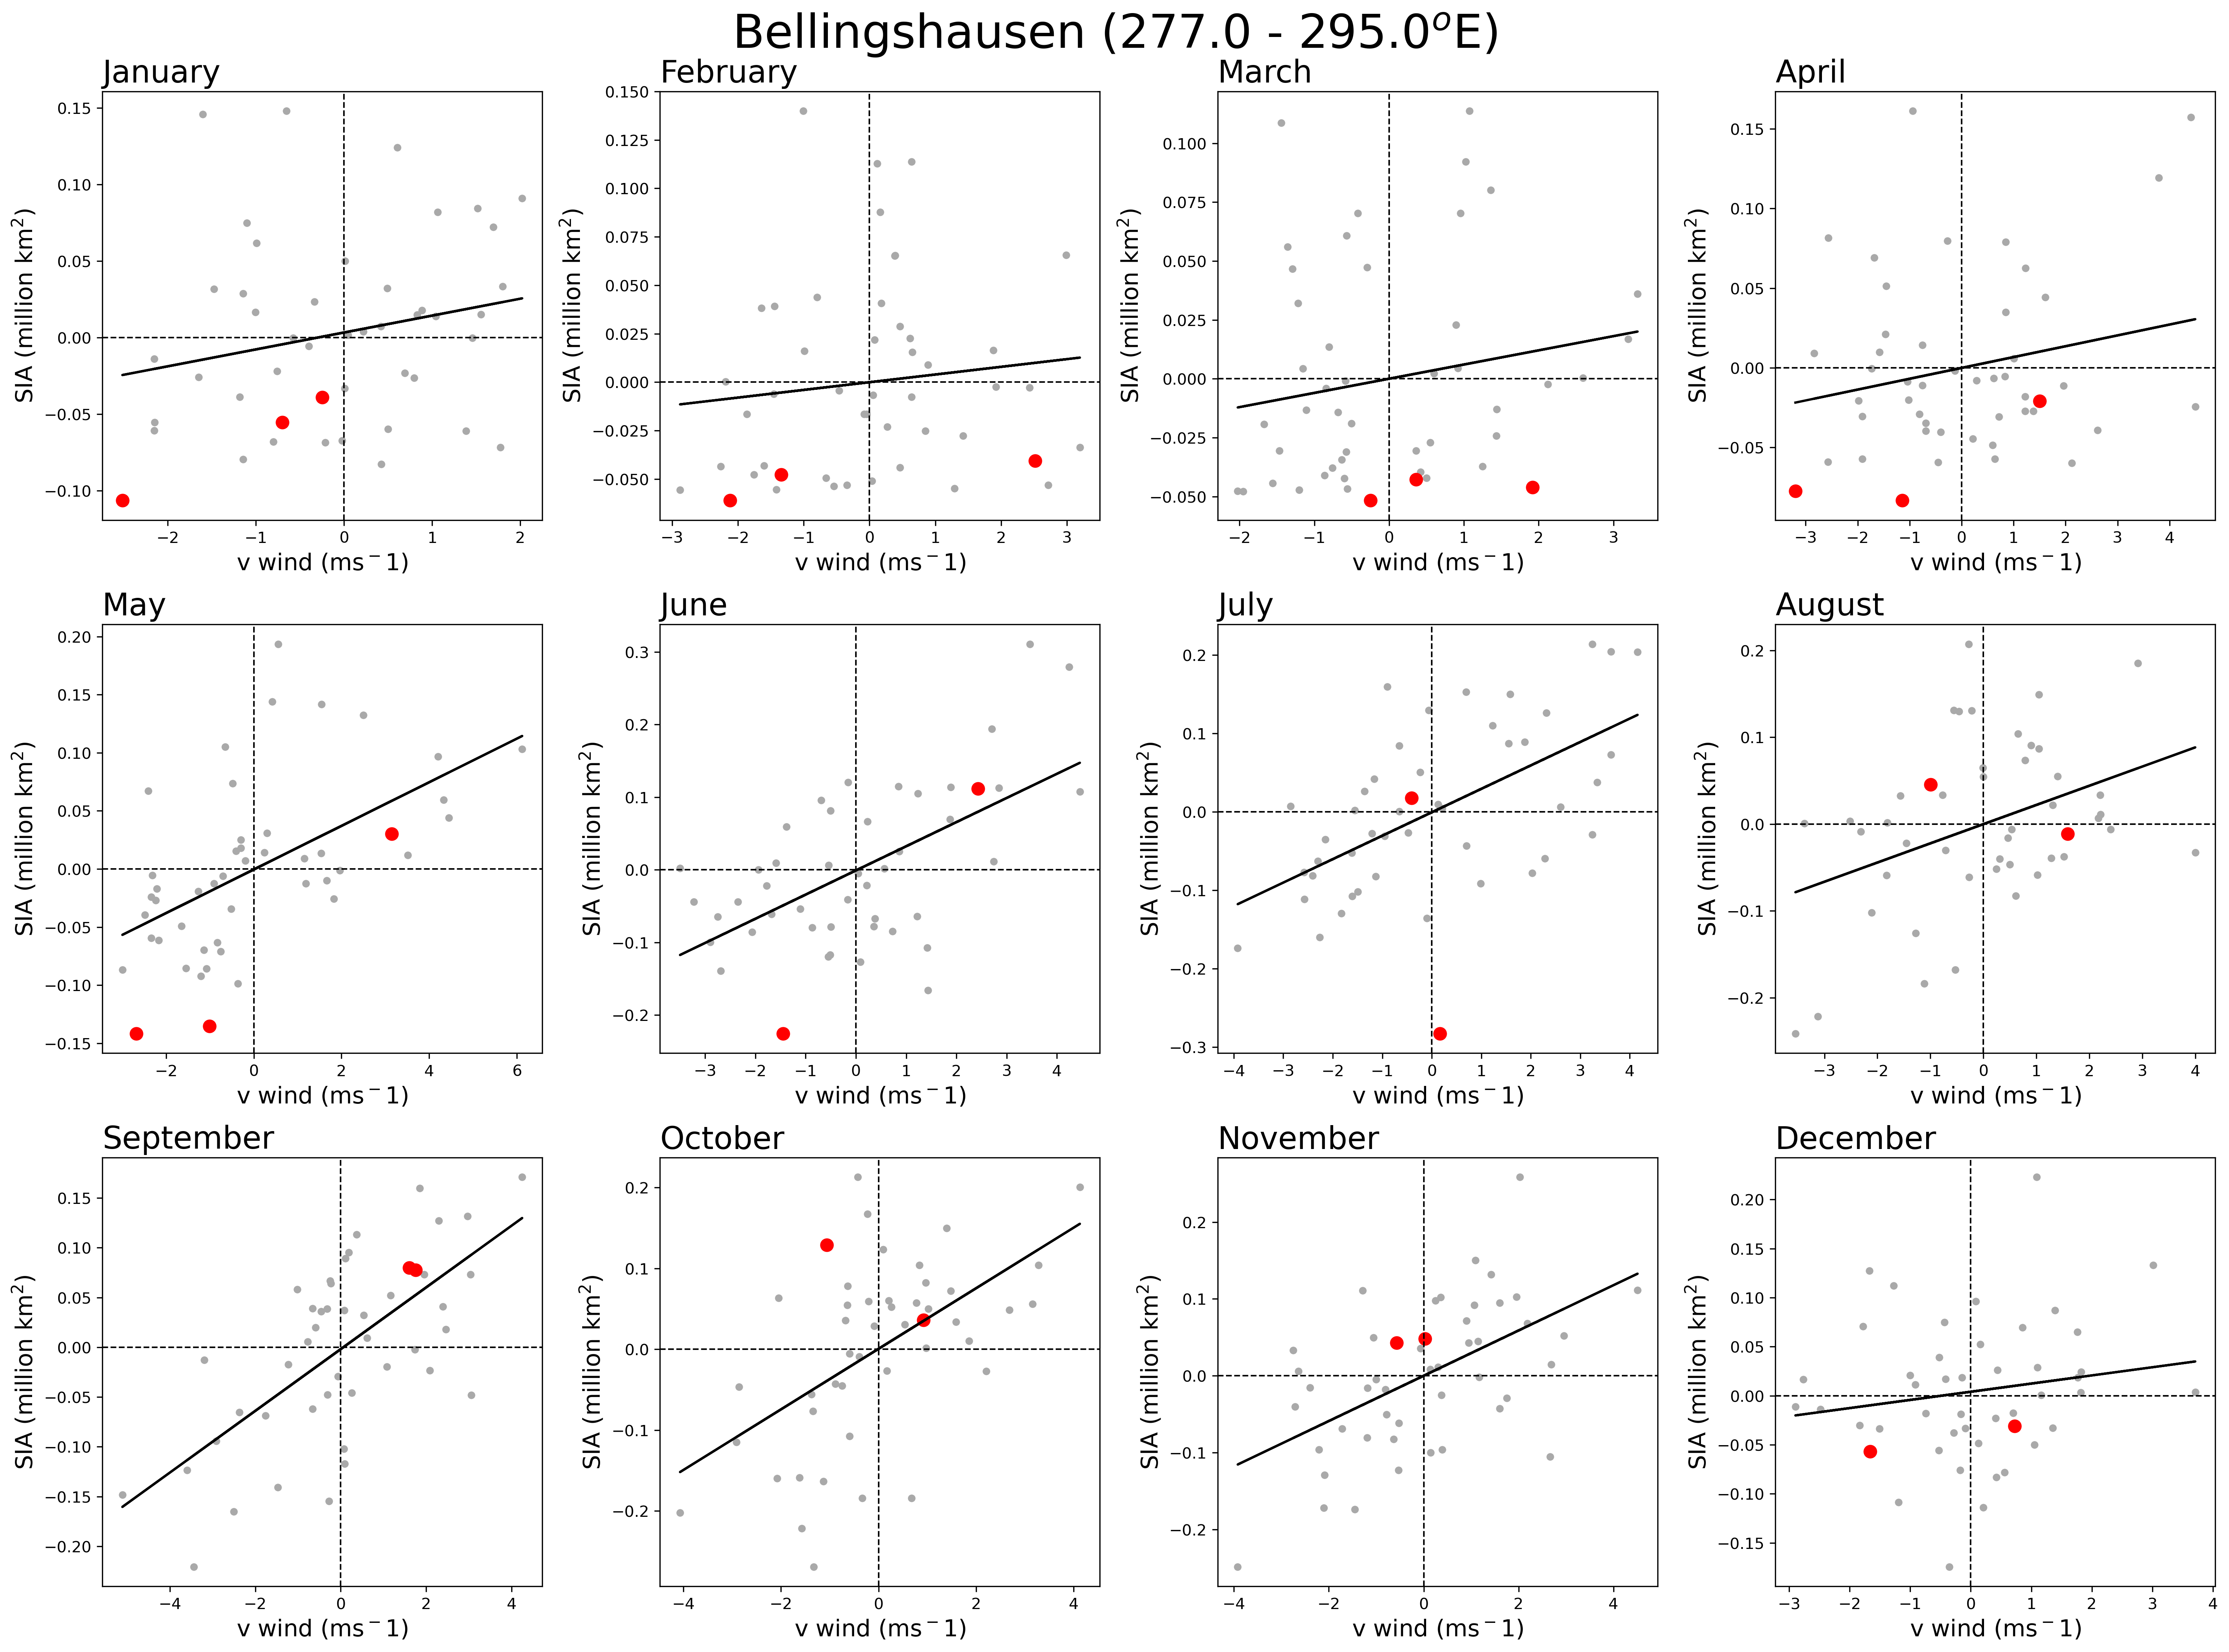

In [45]:

plt.figure(figsize=(20,15), dpi=300)
plsec =   'Bellingshausen'

for m in range(1,13):
        ax = plt.subplot(3, 4, m)
        wind_ice_scatter(plsec,m,[2023, 2024,2025])

pltitle =plsec+' ('+str(sector[plsec]['minlon'])+' - '+str(sector[plsec]['maxlon'])+'$^o$E)'
plt.suptitle(pltitle,fontsize = 30)
plt.tight_layout()
plt.show()


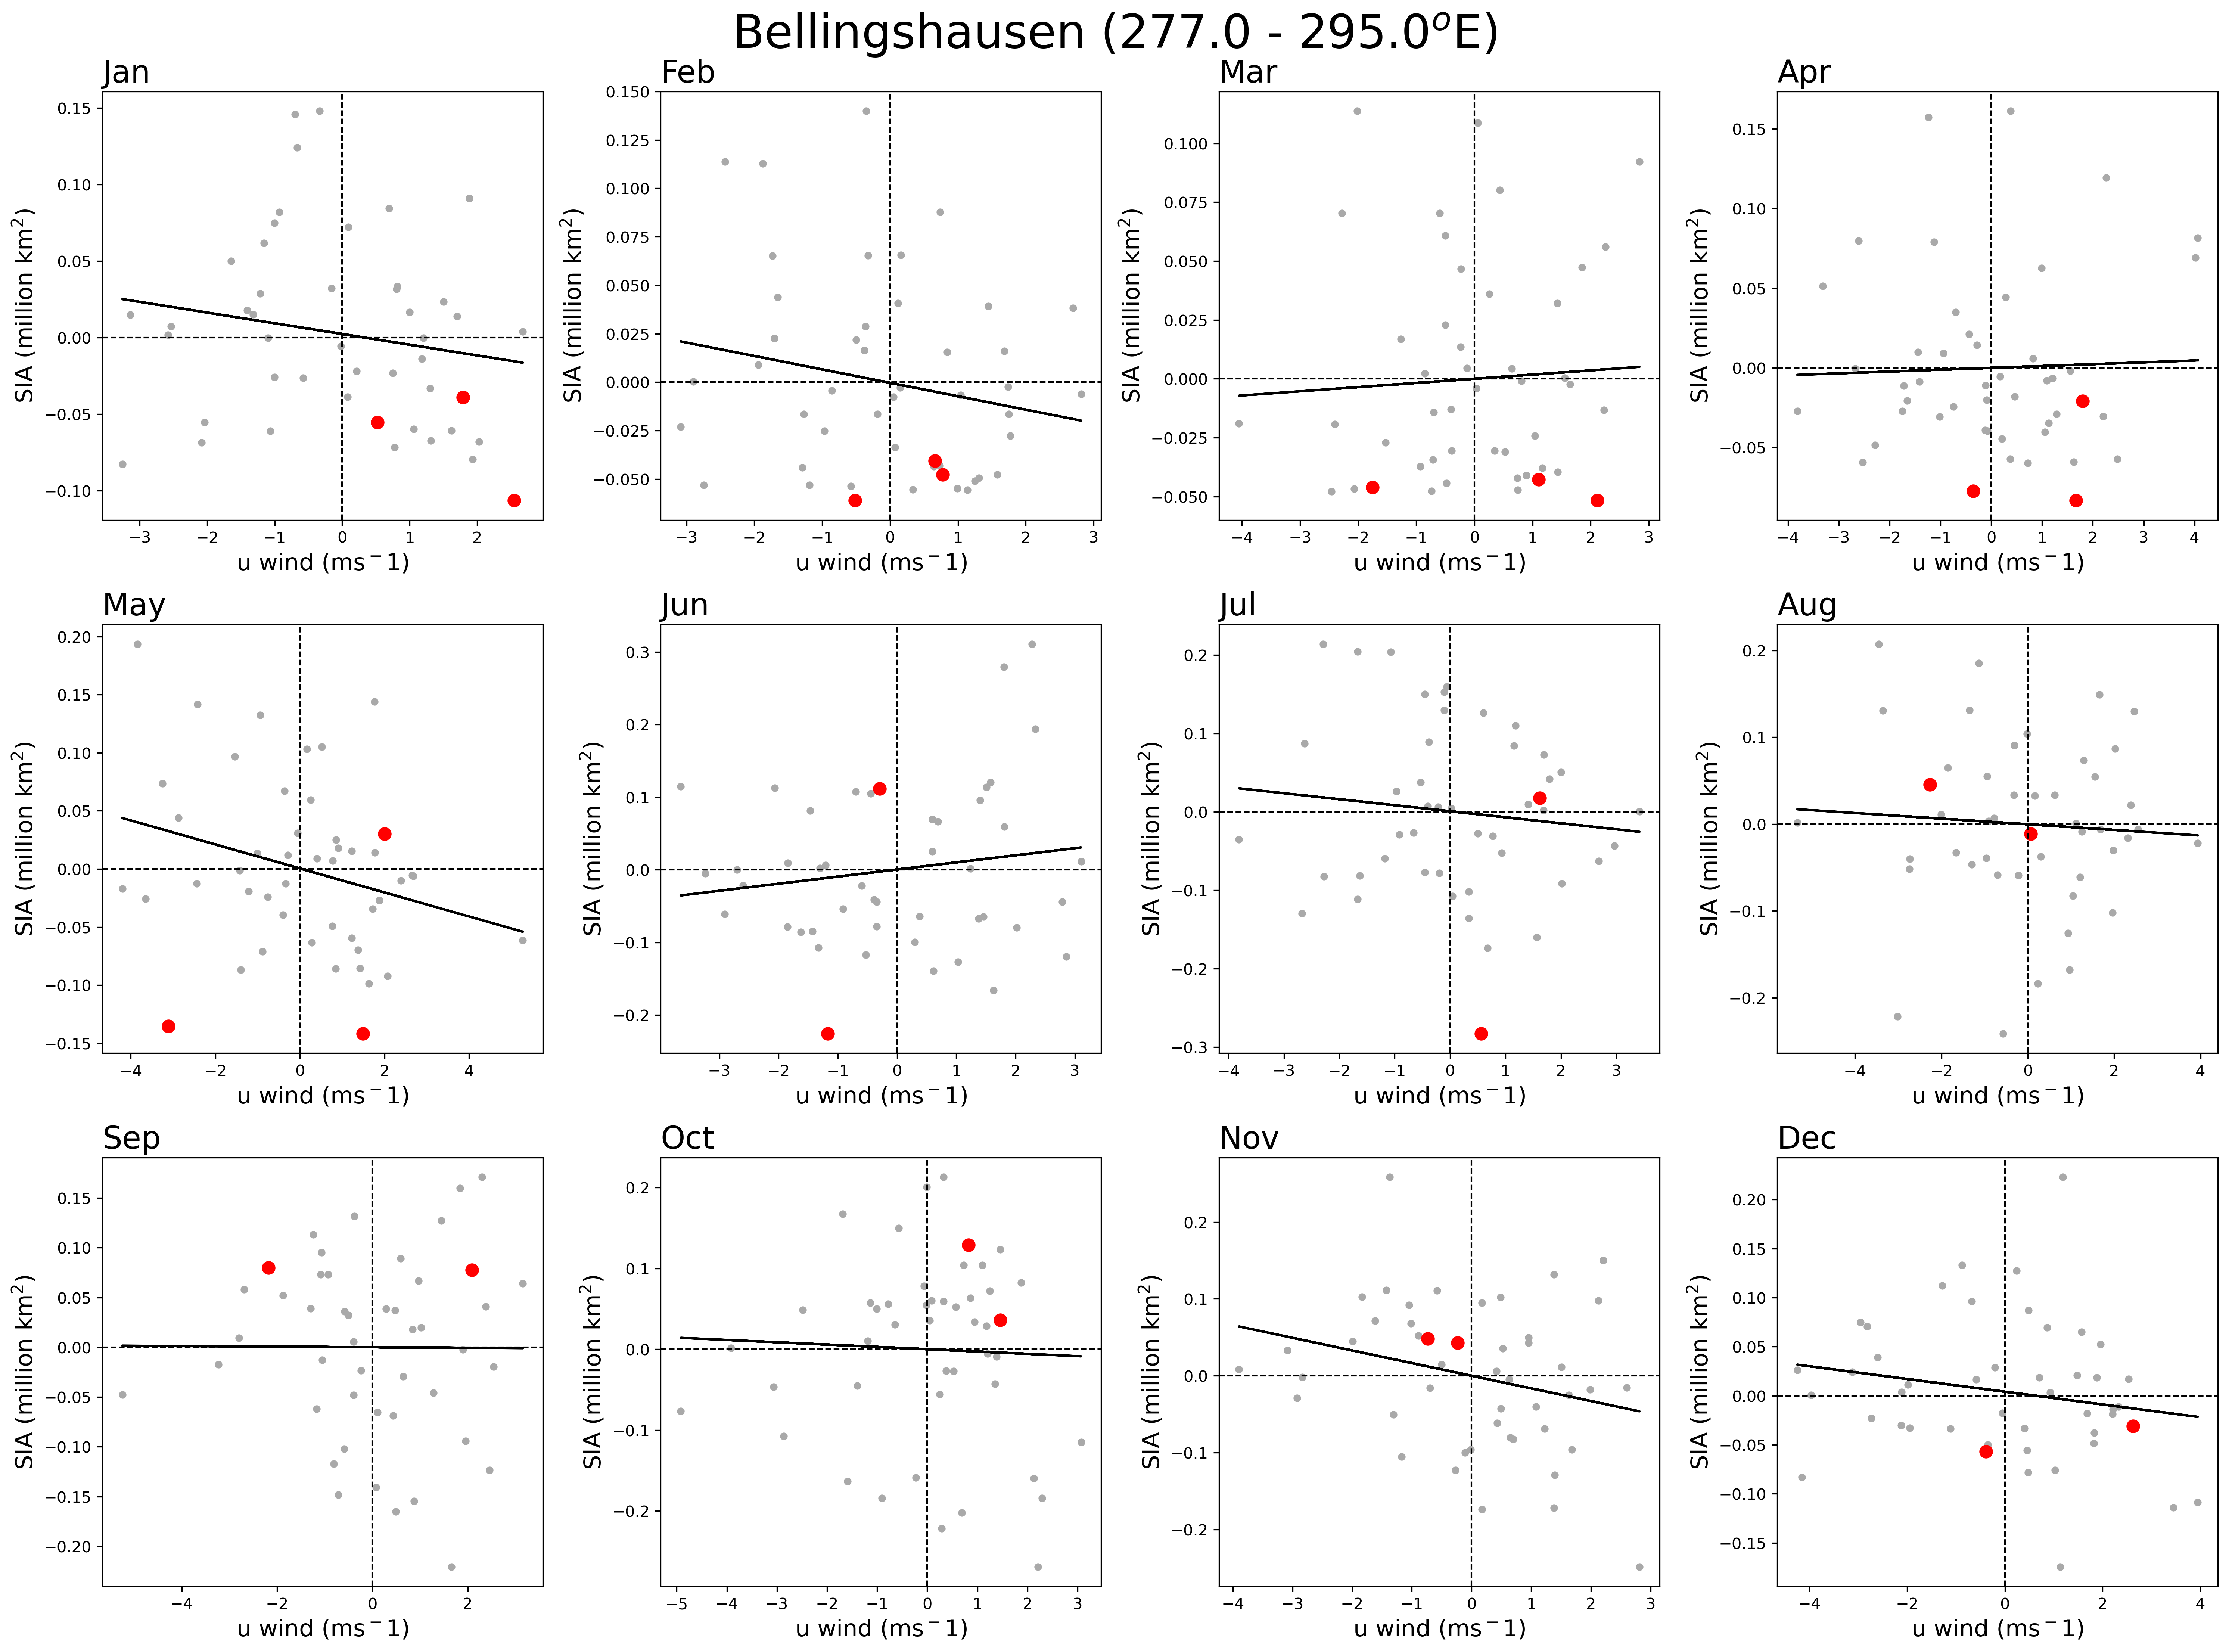

In [70]:

plt.figure(figsize=(20,15), dpi=300)
plsec =   'Bellingshausen'

for m in range(1,13):
        ax = plt.subplot(3, 4, m)
        wind_ice_scatter(plsec,m,[2023, 2024,2025], wind_field="u10")

pltitle =plsec+' ('+str(sector[plsec]['minlon'])+' - '+str(sector[plsec]['maxlon'])+'$^o$E)'
plt.suptitle(pltitle,fontsize = 30)
plt.tight_layout()
plt.show()


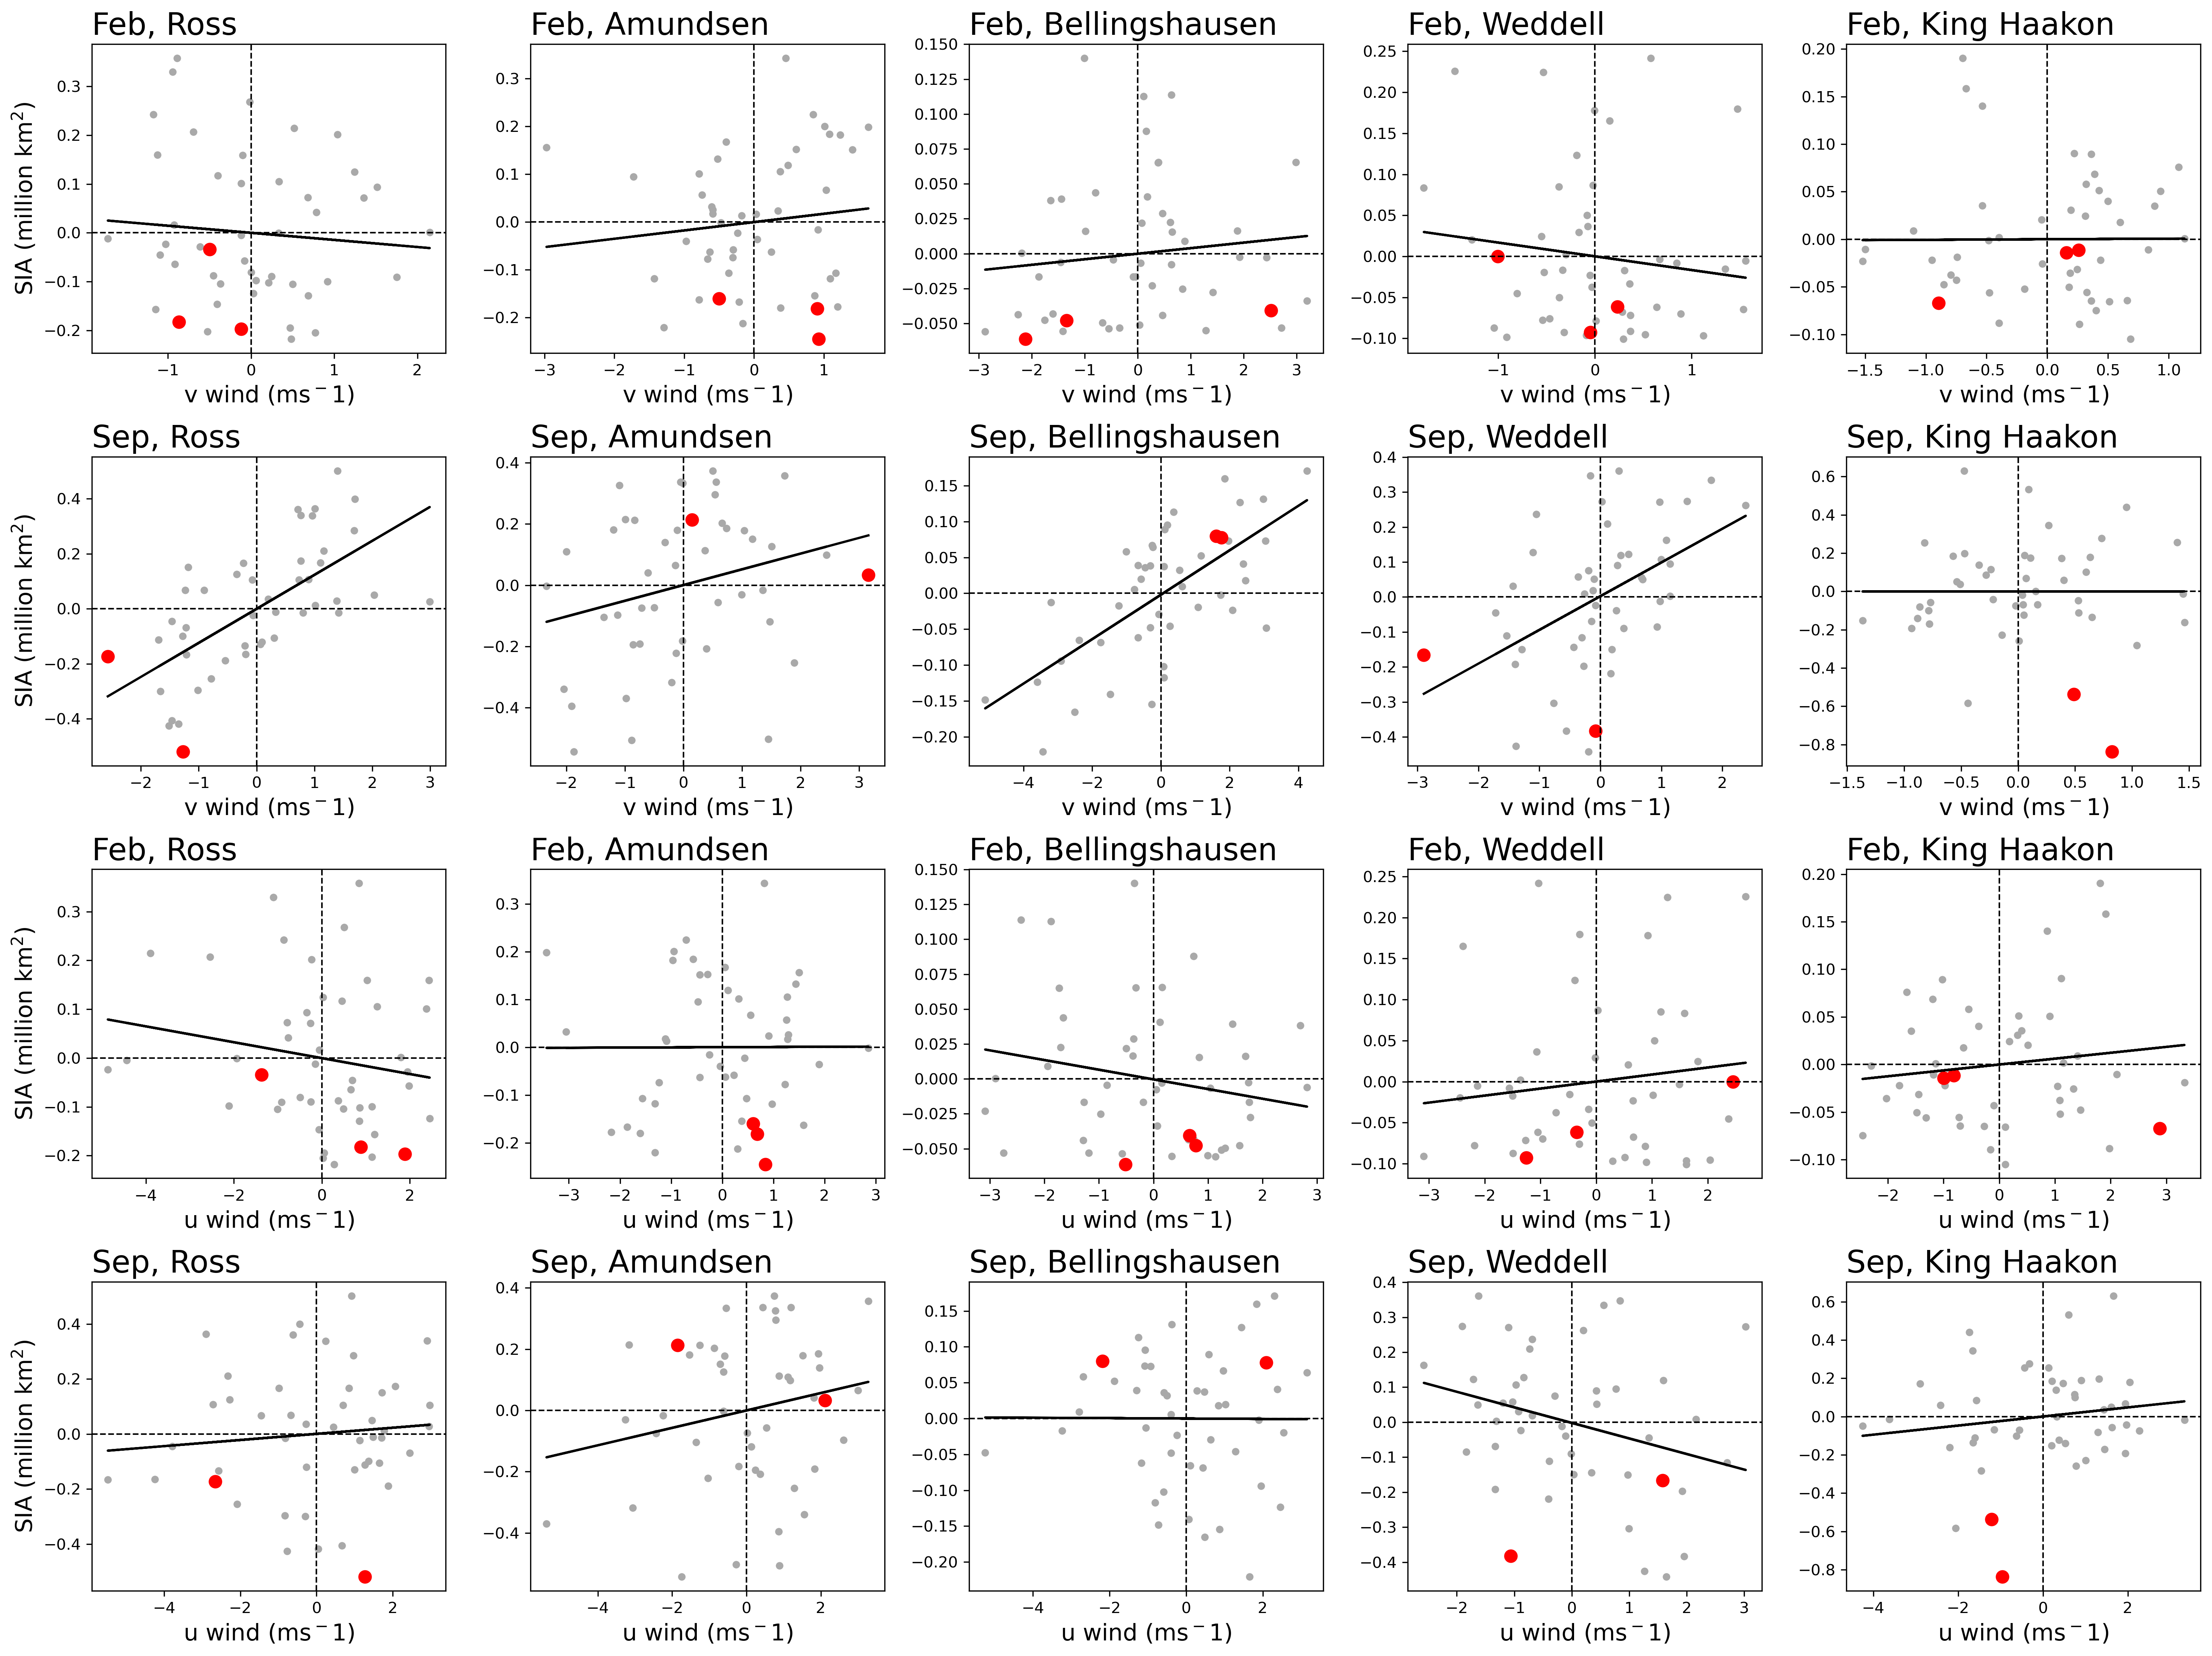

In [78]:

plt.figure(figsize=(20,15), dpi=300)
count = 1

for plsec in list(sector.keys()):
    ax = plt.subplot(4, 5, count)
    wind_ice_scatter(plsec,2,[2023, 2024,2025], wind_field="v10", region_name=plsec, include_region_name=True)
    if (count-1)%5 !=0:
        ax.set_ylabel("")
    count += 1

for plsec in list(sector.keys()):
    ax = plt.subplot(4, 5, count)
    wind_ice_scatter(plsec,9,[2023, 2024,2025], wind_field="v10", region_name=plsec, include_region_name=True)
    if (count-1)%5 !=0:
        ax.set_ylabel("")
    count += 1

for plsec in list(sector.keys()):
    ax = plt.subplot(4, 5, count)
    wind_ice_scatter(plsec,2,[2023, 2024,2025], wind_field="u10", region_name=plsec, include_region_name=True)
    if (count-1)%5 !=0:
        ax.set_ylabel("")
    count += 1

for plsec in list(sector.keys()):
    ax = plt.subplot(4, 5, count)
    wind_ice_scatter(plsec,9,[2023, 2024,2025], wind_field="u10", region_name=plsec, include_region_name=True)
    if (count-1)%5 !=0:
        ax.set_ylabel("")
    count += 1

    

plt.tight_layout()
plt.show()


### Thoughts for further analysis:

1. Create composite maps of sea ice and winds:
    1. During periods of high/low sea ice.
    2. During periods of high/low winds (one set for zonal and one for meridional winds).